# Call Center Analytics using Waston AI Services

This notebook shows you

## Table of contents

1. [Load the required libraries](#loadlibraries)
2. [Load data from Cloud Object Storage](#loaddata)
3. [Visualize Sentiment and Top Keywords using Watson NLU response](#visualizeNLU)
4. [Visualize Emotion Tone using Watson Tone Analyzer response](#visualizeToneAnalyzer)
5. [Summary](#summary)

<a id="loadlibraries"></a>
## Step 1: Load the required libraries

- <a href="https://github.com/amueller/word_cloud/" target="_blank" rel="noopener no referrer">wordcloud</a> is a Python library for generating Word Clouds 

In [1]:
# Run pip install only the first time, once installed on your Spark machine, no need to re-run unless you want to upgrade
!pip install --upgrade --force-reinstall wordcloud

  Using cached matplotlib-2.1.2-cp35-cp35m-manylinux1_x86_64.whl
  Using cached numpy-1.14.1-cp35-cp35m-manylinux1_x86_64.whl
  Using cached Pillow-5.0.0-cp35-cp35m-manylinux1_x86_64.whl
  Using cached six-1.11.0-py2.py3-none-any.whl
  Using cached cycler-0.10.0-py2.py3-none-any.whl
  Using cached pytz-2018.3-py2.py3-none-any.whl
  Using cached pyparsing-2.2.0-py2.py3-none-any.whl
  Using cached python_dateutil-2.6.1-py2.py3-none-any.whl
  Found existing installation: six 1.11.0
    Uninstalling six-1.11.0:
      Successfully uninstalled six-1.11.0
  Found existing installation: numpy 1.14.1
    Uninstalling numpy-1.14.1:
      Successfully uninstalled numpy-1.14.1
  Found existing installation: cycler 0.10.0
    Uninstalling cycler-0.10.0:
      Successfully uninstalled cycler-0.10.0
  Found existing installation: pytz 2018.3
    Uninstalling pytz-2018.3:
      Successfully uninstalled pytz-2018.3
  Found existing installation: pyparsing 2.2.0
    Uninstalling pyparsing-2.2.0:
      S

In [51]:
import ibm_boto3
from botocore.client import Config
import json
import pixiedust
from pixiedust.display import *

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

import matplotlib.pyplot as plt

from pyspark.sql import functions as F
from pyspark.sql.functions import col

<a id="loaddata"> </a>
## Step 2: Load NLU enriched data from your Cloud Object Storage instance

The first step is to load the data. This notebook assumes you have your enriched data stored in cloud object storage. In particular, we load the Watson Natural Language Understanding response for call center logs from cloud object storage.

In [52]:
# The code was removed by DSX for sharing.

In [53]:
# Set the credentials to a generic variable to reference in the rest of the notebook
cos_credentials = credentials_1

In [54]:
# Define Cloud Object Storage client by specifying the credentials for your COS instance
client = ibm_boto3.client(service_name='s3', 
    ibm_api_key_id=cos_credentials['IBM_API_KEY_ID'],
    ibm_auth_endpoint=cos_credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=cos_credentials['ENDPOINT'])

<a id="visualizeNLU"></a>
## Step 3: Visualize Sentiment and Top Keywords using Watson NLU response
Define the function to parse Watson NLU json response and extract sentiment score, sentiment label, and keywords.

In [55]:
# Method to parse NLU response file from Cloud Object Storage
# and return sentiment score, sentiment label, and keywords
def getNLUresponse(COSclient, bucket, filename):
    streaming_body = COSclient.get_object(Bucket=bucket, Key=filename)['Body']
    nlu_response = json.loads(streaming_body.read().decode("utf-8"))
    if nlu_response and nlu_response['sentiment'] \
    and nlu_response['sentiment']['document'] and nlu_response['sentiment']['document']['label']:
        sentiment_score = nlu_response['sentiment']['document']['score']
        sentiment_label = nlu_response['sentiment']['document']['label']
        keywords = list(nlu_response['keywords'])
    else:
        sentiment_score = 0.0
        sentiment_label = None
        keywords = null
        
    return (filename,sentiment_score,sentiment_label,keywords)

In [56]:
# Read enriched files from Cloud Object Storage
# Provide list of files saved in COS that include NLU response
nlu_files=['sample1_nlu.json','sample2_nlu.json', 'sample3_nlu.json', 'sample4_nlu.json']
nlu_header=['filename','sentiment_score','sentiment_label','keywords']
nlu_results = []
bucket = cos_credentials['BUCKET']
for filename in nlu_files:
    print("Processing NLU response from file: ", filename)
    nlu_results.append(getNLUresponse(client,bucket,filename))
    

Processing NLU response from file:  sample1_nlu.json
Processing NLU response from file:  sample2_nlu.json
Processing NLU response from file:  sample3_nlu.json
Processing NLU response from file:  sample4_nlu.json


In [57]:
print(nlu_results)

[('sample1_nlu.json', -0.854972, 'negative', [{'text': 'frustrating experience', 'relevance': 0.971148}, {'text': 'MQ software', 'relevance': 0.921691}, {'text': 'mac', 'relevance': 0.588912}]), ('sample2_nlu.json', 0.0, 'neutral', [{'text': 'MQ software', 'relevance': 0.986784}, {'text': 'password', 'relevance': 0.708382}, {'text': 'status', 'relevance': 0.518698}, {'text': 'ticket', 'relevance': 0.517027}]), ('sample3_nlu.json', 0.952419, 'positive', [{'text': 'outstanding service', 'relevance': 0.983314}]), ('sample4_nlu.json', -0.887123, 'negative', [{'text': 'poor service', 'relevance': 0.948805}, {'text': 'charges', 'relevance': 0.67714}, {'text': 'response', 'relevance': 0.551408}])]


Map the parsed NLU responses into a Spark dataframe, one record for each file, where each file is the NLU response for one call center record.

In [59]:
callcenterlogs_nluDF = spark.createDataFrame(nlu_results, nlu_header)

In [60]:
# Common validation calls
print(type(callcenterlogs_nluDF))
callcenterlogs_nluDF.printSchema()
callcenterlogs_nluDF.show()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- filename: string (nullable = true)
 |-- sentiment_score: double (nullable = true)
 |-- sentiment_label: string (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)

+----------------+---------------+---------------+--------------------+
|        filename|sentiment_score|sentiment_label|            keywords|
+----------------+---------------+---------------+--------------------+
|sample1_nlu.json|      -0.854972|       negative|[Map(relevance ->...|
|sample2_nlu.json|            0.0|        neutral|[Map(relevance ->...|
|sample3_nlu.json|       0.952419|       positive|[Map(relevance ->...|
|sample4_nlu.json|      -0.887123|       negative|[Map(relevance ->...|
+----------------+---------------+---------------+--------------------+



### Sentiment plots using PixieDust
Leverage PixieDust to plot sentiment labels as a pie-chart showing how many positive, negative, and neutral calls are received.

In [61]:
## Ignore any records with null sentiment label
callcenterlogs_nluDF = callcenterlogs_nluDF.where(col('sentiment_label').isNotNull())
perlabel_sentimentDF = callcenterlogs_nluDF.groupBy('sentiment_label')\
                              .agg(F.count('filename')\
                              .alias('num_calls'))

## Take a look
perlabel_sentimentDF.show()

+---------------+---------+
|sentiment_label|num_calls|
+---------------+---------+
|       positive|        1|
|        neutral|        1|
|       negative|        2|
+---------------+---------+




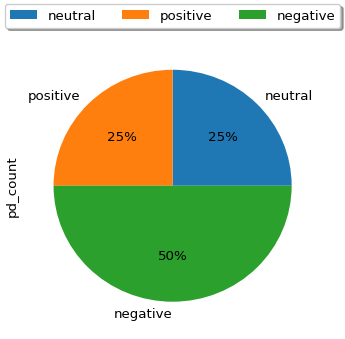

In [62]:
# Call Pixiedust to visualize sentiment data
display(callcenterlogs_nluDF)

### Keywords visualization using Word Cloud
Next, we process the NLU keywords results to understand what are the top keywords referenced in the call center interactions. This would be very helpful in delivering insights what are the main topics being referenced in these call center interactions.

In [63]:
from pyspark.sql.functions import explode

# Explode keywords
callcenterlogs_nluDF = callcenterlogs_nluDF.select(explode('keywords').alias('topkeywords'))
callcenterlogs_nluDF = callcenterlogs_nluDF.select('topkeywords').rdd.map(lambda row: row[0]).toDF()


/usr/local/src/spark21master/spark/python/pyspark/sql/session.py:340: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [64]:
callcenterlogs_nluDF.head(4)

[Row(relevance='0.971148', text='frustrating experience'),
 Row(relevance='0.921691', text='MQ software'),
 Row(relevance='0.588912', text='mac'),
 Row(relevance='0.986784', text='MQ software')]

In [65]:
# UDF to return lower case of word
def toLowerCase(word):
    return word.lower()

In [66]:
# Process extracted keywords to change to lower case
udfLowerCase = udf(toLowerCase, StringType())
callcenterlogsTopKeywordsDF = callcenterlogs_nluDF.withColumn('topkeywords',udfLowerCase('text'))


In [67]:
# Group by topkeywords and compute average relevance per keyword and also number of calls for each keyword
callcenterlogsKwdsNumDF = callcenterlogsTopKeywordsDF.groupBy('topkeywords')\
                              .agg(F.count('topkeywords').alias('kwdsnumcalls'))
callcenterlogsKwdsRelDF = callcenterlogsTopKeywordsDF.groupBy('topkeywords')\
                          .agg(F.avg('relevance').alias('kwdsavgrelevance'))


In [68]:
# join the keywords nunber and keywords relevance dataframes into one
callcenterlogsKeywordsDF = callcenterlogsKwdsNumDF.join(callcenterlogsKwdsRelDF,'topkeywords','outer')

# Define keyword score as product of number of calls expressing that keyword and average relevance of that keyword
callcenterlogsKeywordsDF = callcenterlogsKeywordsDF.withColumn('keyword_score',callcenterlogsKeywordsDF.kwdsnumcalls * callcenterlogsKeywordsDF.kwdsavgrelevance)

# Sort dataframe in descending order of KEYWORD_SCORE
callcenterlogsKeywordsDF = callcenterlogsKeywordsDF.orderBy('keyword_score',ascending=False)

# Remove None keywords
callcenterlogsKeywordsDF = callcenterlogsKeywordsDF.where(col('topkeywords').isNotNull())


In [69]:
print("Top Keywords from call center logs")
callcenterlogsKeywordsDF.show()

Top Keywords from call center logs
+--------------------+------------+------------------+------------------+
|         topkeywords|kwdsnumcalls|  kwdsavgrelevance|     keyword_score|
+--------------------+------------+------------------+------------------+
|         mq software|           2|0.9542375000000001|1.9084750000000001|
| outstanding service|           1|          0.983314|          0.983314|
|frustrating exper...|           1|          0.971148|          0.971148|
|        poor service|           1|          0.948805|          0.948805|
|            password|           1|          0.708382|          0.708382|
|             charges|           1|           0.67714|           0.67714|
|                 mac|           1|          0.588912|          0.588912|
|            response|           1|          0.551408|          0.551408|
|              status|           1|          0.518698|          0.518698|
|              ticket|           1|          0.517027|          0.517027|
+--


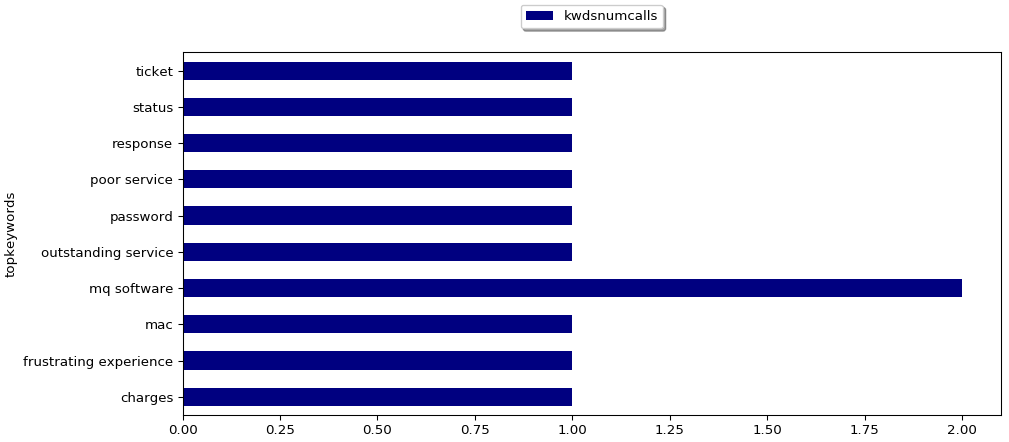

In [70]:
display(callcenterlogsKeywordsDF)

In [71]:
# Map to Pandas DataFrame
callcenterlogsKeywordsPandas = callcenterlogsKeywordsDF.toPandas()

In [72]:
from wordcloud import WordCloud

# Process Pandas DataFrame in the right format to leverage wordcloud.py for plotting
# See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py 
def prepForWordCloud(pandasDF,n):
    kwdList = pandasDF['topkeywords']
    sizeList = pandasDF['keyword_score']
    kwdSize = {}
    for i in range(n):
        kwd=kwdList[i]
        size=sizeList[i]
        kwdSize[kwd] = size
    return kwdSize

/gpfs/fs01/user/sfda-f4889f975f5a78-7db7fa961766/.local/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


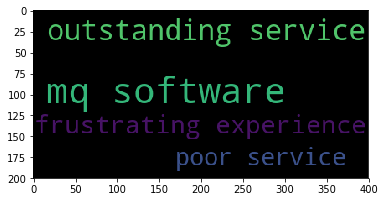

In [73]:
%matplotlib inline
maxWords = len(callcenterlogsKeywordsPandas)
nWords = 4

#Generating wordcloud. Relative scaling value is to adjust the importance of a frequency word.
#See documentation: https://github.com/amueller/word_cloud/blob/master/wordcloud/wordcloud.py
callcenterlogsKwdFreq = prepForWordCloud(callcenterlogsKeywordsPandas,nWords)
callcenterlogsWordCloud = WordCloud(max_words=maxWords,relative_scaling=0,normalize_plurals=False).generate_from_frequencies(callcenterlogsKwdFreq)

plt.imshow(callcenterlogsWordCloud)

# If need to support multiple side-by-side word clouds, use commented lines below

#fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (23, 10))

## Set titles for images
#ax[0].set_title('Top Keywords from logs of call 1')
#ax[1].set_title('Top Keywords from logs of call 2')

                
## Plot word clouds
#ax[0].imshow(callcenterlogs1WordCloud)
#ax[1].imshow(callcenterlogs2WordCloud)

# turn off axis and ticks
#plt.axis("off")
#ax[0].tick_params(axis='both',which='both',bottom='off',top='off',left='off',right='off',
#                 labelbottom='off',labeltop='off',labelleft='off',labelright='off') 
#ax[1].tick_params(axis='both',which='both',bottom='off',top='off',left='off',right='off',
#                 labelbottom='off',labeltop='off',labelleft='off',labelright='off') 


#plt.show()

<a id="visualizeToneAnalyzer"></a>
## Step 4: Visualize Emotion Tone using Watson Tone Analyzer response
Define the function to parse Watson Tone Analyzer json response and extract emotion tone labels and scores.

In [74]:
# Method to parse Tone Analyzer response file from Cloud Object Storage
# and return emotion tone labels and scores
toneID_list=['excited','frustrated','impolite','polite','sad','satisfied','sympathetic']
def getTAresponse(COSclient, bucket, filename):
    streaming_body = COSclient.get_object(Bucket=bucket, Key=filename)['Body']
    ta_response = json.loads(streaming_body.read().decode("utf-8"))
    if ta_response and ta_response['utterances_tone']:
        # Assume one set of tones per file; if file is created to include a number of utterances
        # we will need to change this code
        tones = ta_response['utterances_tone'][0]['tones']
    else:
        tones = []
    return (filename, tones)

In [75]:
toneanalyzer_files=['sample1_ta.json','sample2_ta.json']
toneanalyzer_header=['filename','tones']
toneanalyzer_results = []
bucket = cos_credentials['BUCKET']
for filename in toneanalyzer_files:
    print("Processing Tone Analyzer response from file: ", filename)
    response= getTAresponse(client,bucket,filename)
    toneanalyzer_results.append(response)

Processing Tone Analyzer response from file:  sample1_ta.json
Processing Tone Analyzer response from file:  sample2_ta.json


In [76]:
callcenterlogs_taDF = spark.createDataFrame(toneanalyzer_results, toneanalyzer_header)

In [77]:
callcenterlogs_taDF.head(4)

[Row(filename='sample1_ta.json', tones=[{'tone_name': 'Polite', 'tone_id': 'polite', 'score': '0.639322'}, {'tone_name': 'Sympathetic', 'tone_id': 'sympathetic', 'score': '0.705884'}]),
 Row(filename='sample2_ta.json', tones=[{'tone_name': 'Polite', 'tone_id': 'polite', 'score': '0.639322'}, {'tone_name': 'Sympathetic', 'tone_id': 'sympathetic', 'score': '0.705884'}])]

In [78]:
callcenterlogs_taDF.printSchema()

root
 |-- filename: string (nullable = true)
 |-- tones: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: string (valueContainsNull = true)



In [79]:
# If not imported earlier, import explode
from pyspark.sql.functions import explode

# Explode keywords
callcenterlogs_taDF = callcenterlogs_taDF.select(explode('tones').alias('toptones'))
callcenterlogs_taDF = callcenterlogs_taDF.select('toptones').rdd.map(lambda row: row[0]).toDF()

/usr/local/src/spark21master/spark/python/pyspark/sql/session.py:340: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [80]:
# Print schema and note that score is of type string
callcenterlogs_taDF.printSchema()

root
 |-- score: string (nullable = true)
 |-- tone_id: string (nullable = true)
 |-- tone_name: string (nullable = true)



In [81]:
# Cast the score column from String to Double
callcenterlogs_taDF = callcenterlogs_taDF.withColumn("score", col("score").cast("double"))

In [82]:
# Print schema to verify score is now of type double
callcenterlogs_taDF.printSchema()

root
 |-- score: double (nullable = true)
 |-- tone_id: string (nullable = true)
 |-- tone_name: string (nullable = true)



In [83]:
callcenterlogs_taDF.head(5)

[Row(score=0.639322, tone_id='polite', tone_name='Polite'),
 Row(score=0.705884, tone_id='sympathetic', tone_name='Sympathetic'),
 Row(score=0.639322, tone_id='polite', tone_name='Polite'),
 Row(score=0.705884, tone_id='sympathetic', tone_name='Sympathetic')]


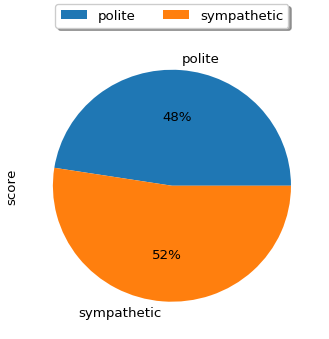

In [84]:
display(callcenterlogs_taDF)

### Stop Here
Cells below are not needed when using PixieDust as it simplifies much of the processing executed in the steps below.

However, we're keeping them here commented for reference, in case you want to explore other operations.

In [30]:
# Group by toptones and compute average score per tone and also number of calls for each tone
callcenterlogsTonesNumDF = callcenterlogs_taDF.groupBy('tone_id')\
                           .agg(F.count('tone_id').alias('tonesnumcalls'))
callcenterlogsTonesScoreDF = callcenterlogs_taDF.groupBy('tone_id')\
                          .agg(F.avg('score').alias('tonesavgscore'))



In [31]:
# join the tones nunber and tones scores dataframes into one
callcenterlogsTonesDF = callcenterlogsTonesNumDF.join(callcenterlogsTonesScoreDF,'tone_id','outer')

# Define tones score as product of number of calls expressing that tone and average score of that tone
callcenterlogsTonesDF = callcenterlogsTonesDF.withColumn('tones_score',callcenterlogsTonesDF.tonesnumcalls * callcenterlogsTonesDF.tonesavgscore)

# Sort dataframe in descending order of tones_score
callcenterlogsTonesDF = callcenterlogsTonesDF.orderBy('tones_score',ascending=False)

# Remove None tones
callcenterlogsTonesDF = callcenterlogsTonesDF.where(col('tone_id').isNotNull())

In [ ]:
#response= getTAresponse(client,bucket,filename)
#print(json.dumps(resp, indent=4, sort_keys=True))

<a id="summary"></a>
## Summary
Write summary here